In [5]:
!python3 -m pip install scikit-learn

In [2]:
!python3 -m site

sys.path = [
    '/home/hai/code/stud_assistant',
    '/home/hai/miniconda3/lib/python312.zip',
    '/home/hai/miniconda3/lib/python3.12',
    '/home/hai/miniconda3/lib/python3.12/lib-dynload',
    '/home/hai/miniconda3/lib/python3.12/site-packages',
]
USER_BASE: '/home/hai/.local' (exists)
USER_SITE: '/home/hai/.local/lib/python3.12/site-packages' (doesn't exist)
ENABLE_USER_SITE: True


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn import datasets
import ipywidgets as widgets
from ipywidgets import interact

In [3]:

def show_pca(cov_11=3, cov_12=3, cov_21=3, cov_22=4):
    rng = np.random.RandomState(42)
    n_samples = 500
    cov = [[cov_11, cov_12], [cov_21, cov_22]]
    X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n_samples)
    pca = PCA(n_components=2).fit(X)
    
    
    plt.scatter(X[:, 0], X[:, 1], alpha=0.3, label="samples")
    for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
        comp = comp * var  # scale component by its variance explanation power
        arrow_color = 'green' if i == 0 else 'red'
        plt.arrow(
            0, 0, comp[0], comp[1],
            head_width=0.2, head_length=0.3,
            fc=arrow_color, ec=arrow_color,
            length_includes_head=True,
            label=f"Component {i+1}",
            linewidth=2,
        )
    plt.gca().set(
        aspect="equal",
        title="2-dimensional dataset with principal components",
        xlabel="first feature",
        ylabel="second feature",
    )
    plt.legend()
    plt.show()

interact(show_pca, 
         cov_11=widgets.FloatSlider(value=3, min=-10, max=10, step=1, description='Cov 1 1'),
         cov_12=widgets.FloatSlider(value=3, min=-10, max=10, step=1, description='Cov 1 2'),
         cov_21=widgets.FloatSlider(value=3, min=-10, max=10, step=1, description='Cov 2 1'),
         cov_22=widgets.FloatSlider(value=4, min=-10, max=10, step=1, description='Cov 2 2'),
         )

interactive(children=(FloatSlider(value=3.0, description='Cov 1 1', max=10.0, min=-10.0, step=1.0), FloatSlide…

<function __main__.show_pca(cov_11=3, cov_12=3, cov_21=3, cov_22=4)>

Notes for notebook, remove later:
* how to plot and how to look up the documentation
* explain the methods in detail, step by step
* show linear models with feature selection (use check boxes)
* show their performances
* show simple pcr and compare to linear regression
* show pls and compare predictive powers
    * ask for problems with single data point analysis (if we don't know true value, best choice and why?)
* show cases where LR performs better than PLS
    * show visualtion of the intrinsic dimension

In [4]:
diabetes = datasets.load_diabetes()
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [5]:
diabetes_df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
diabetes_df['target'] = diabetes.target
diabetes_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


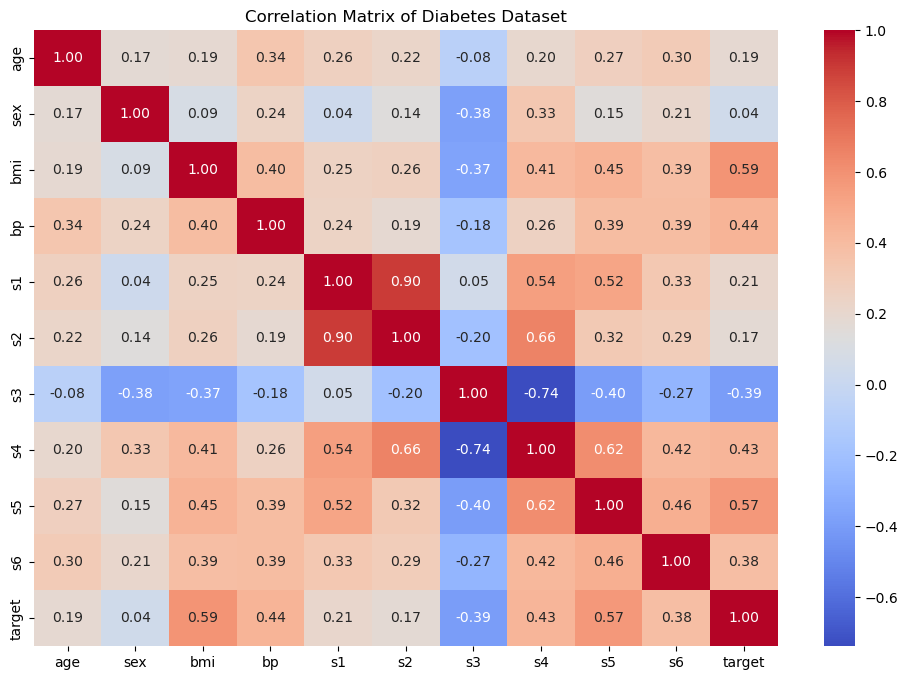

In [6]:
corr_matrix = diabetes_df.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Diabetes Dataset')
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, test_size=0.2, random_state=42)

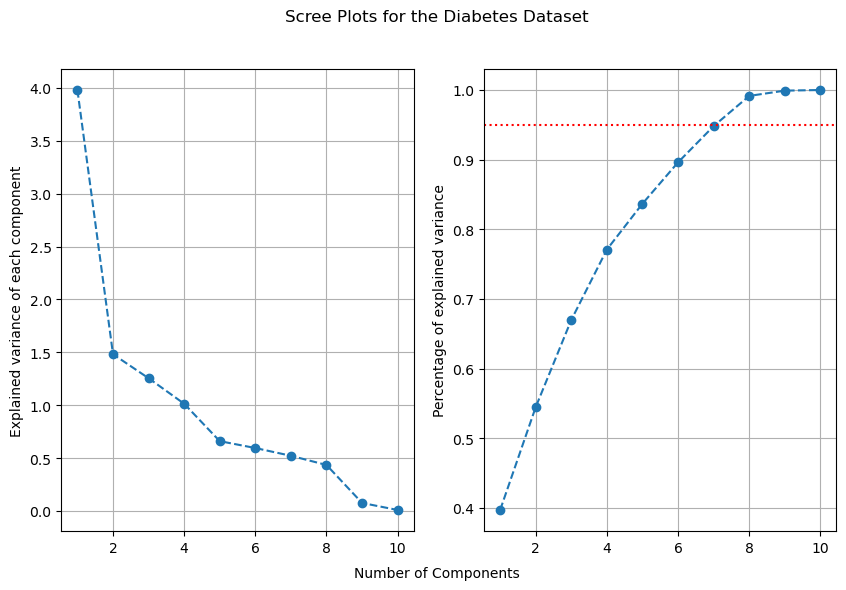

In [10]:
scaler_new = StandardScaler().fit(X_train)
pca_new = PCA(n_components=10).fit(scaler_new.transform(X_train))
fig, ax = plt.subplots(1,2, sharex=True, figsize=(10, 6))
fig.suptitle('Scree Plots for the Diabetes Dataset')
ax[0].plot(range(1, len(pca_new.explained_variance_ratio_) + 1), pca_new.explained_variance_, marker='o', linestyle='--')
ax[0].set_ylabel('Explained variance of each component')
ax[0].grid(True)

ax[1].plot(range(1, len(pca_new.explained_variance_ratio_) + 1), np.cumsum(pca_new.explained_variance_ratio_), marker='o', linestyle='--')
ax[1].axhline(y=0.95, color='r', linestyle='dotted')
ax[1].set_ylabel('Percentage of explained variance')
ax[1].grid(True)

fig.text(0.5, 0.04, 'Number of Components', ha='center', va='center')
plt.show();

## Evaluating models

In [18]:
single_data_point = X_test[0].reshape(1, -1)  # shape: (1, n_features)

# Make predictions
pred_lr  = lr.predict(single_data_point)[0]    # scalar or 1D array
pred_pcr = pcr.predict(single_data_point)[0]   # scalar or 1D array
pred_pls = pls.predict(single_data_point)[0]   # scalar or 1D array

# Print out the predictions
print(f"Single data point from X_test: {single_data_point}")
print(f"Linear Regression prediction: {pred_lr}")
print(f"PCR (PCA + LR) prediction:    {pred_pcr}")
print(f"PLS prediction:               {pred_pls}")
print(f"True value:                   {y_test[0]}")

Single data point from X_test: [[ 0.04534098 -0.04464164 -0.00620595 -0.01599898  0.1250187   0.1251981
   0.019187    0.03430886  0.03243232 -0.0052198 ]]
Linear Regression prediction: 139.54755840379613
PCR (PCA + LR) prediction:    163.81021518618954
PLS prediction:               130.63153589672152
True value:                   219.0


In [19]:
single_data_point = X_train[0].reshape(1, -1)  # shape: (1, n_features)

# Make predictions
pred_lr  = lr.predict(single_data_point)[0]    # scalar or 1D array
pred_pcr = pcr.predict(single_data_point)[0]   # scalar or 1D array
pred_pls = pls.predict(single_data_point)[0]   # scalar or 1D array

# Print out the predictions
print(f"Single data point from X_train:{single_data_point}")
print(f"Linear Regression prediction: {pred_lr}")
print(f"PCR (PCA + LR) prediction:    {pred_pcr}")
print(f"PLS prediction:               {pred_pls}")
print(f"True value:                   {y_test[0]}")

Single data point from X_train:[[ 0.07076875  0.05068012  0.01211685  0.0563009   0.03420581  0.04941617
  -0.03971921  0.03430886  0.02736405 -0.0010777 ]]
Linear Regression prediction: 184.69998932447166
PCR (PCA + LR) prediction:    202.09937658996503
PLS prediction:               182.2891383857713
True value:                   219.0


In [26]:
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score


In [33]:

def report_generalisation_errors(metric=mean_squared_error, metric_name="MSE", n_comps=6, verbose=False):
    # ------------------------------
    # Assume X_train, X_test, y_train, y_test already exist
    # and X is 1D or we're focusing on the first column of X
    # ------------------------------
    
    # -------------------------
    # (A) Simple Linear Regression
    # -------------------------

    printv = print if verbose else lambda *x: None
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    
    mse_lr = metric(y_test, y_pred_lr)
    printv(f"MSE (Linear Regression): {mse_lr}")
    # print(f"Relative MSE (LR): {mse_lr / np.average(y_test ** 2)}\n")
    
    
    # -------------------------
    # (B) PCR: PCA + Linear Regression
    # -------------------------
    pcr = Pipeline([
        ("standardscaler", StandardScaler()),
        ("pca", PCA(n_components=n_comps)),
        ("lr", LinearRegression())
    ])
    pcr.fit(X_train, y_train)
    y_pred_pcr = pcr.predict(X_test)
    
    mse_pcr = metric(y_test, y_pred_pcr)
    printv(f"MSE (PCR): {mse_pcr}")
    # print(f"Relative MSE (PCR): {mse_pcr / np.average(y_test ** 2)}\n")
    
    
    # -------------------------
    # (C) PLS
    # -------------------------
    pls = PLSRegression(n_components=n_comps)
    pls.fit(X_train, y_train)
    y_pred_pls = pls.predict(X_test)
    
    mse_pls = metric(y_test, y_pred_pls)
    printv(f"MSE (PLS): {mse_pls}")
    # print(f"Relative MSE (PLS): {mse_pls / np.average(y_test ** 2)}\n")

    return mse_lr, mse_pcr, mse_pls


In [34]:
report_generalisation_errors(r2_score, "r2_score")

(0.4526027629719196, 0.43801982193121125, 0.4631964223665963)

In [35]:
report_generalisation_errors(mean_squared_error, "MSE")

(2900.1936284934804, 2977.4562630668242, 2844.066813448385)

In [36]:
report_generalisation_errors(explained_variance_score, "explained_variance_score")

(0.4554925102890147, 0.4415576714920365, 0.4661262357490493)

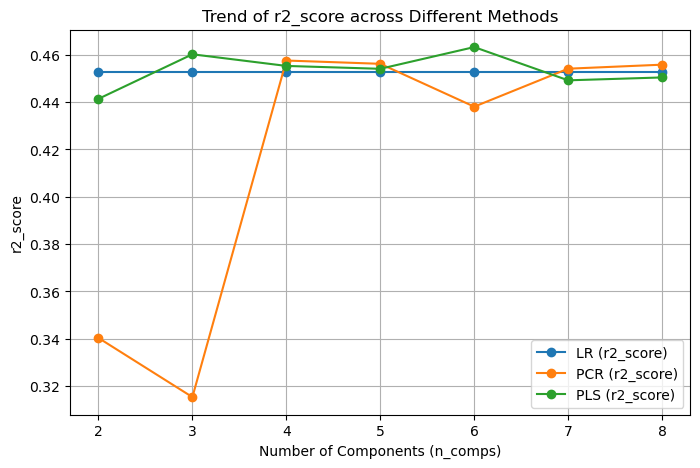

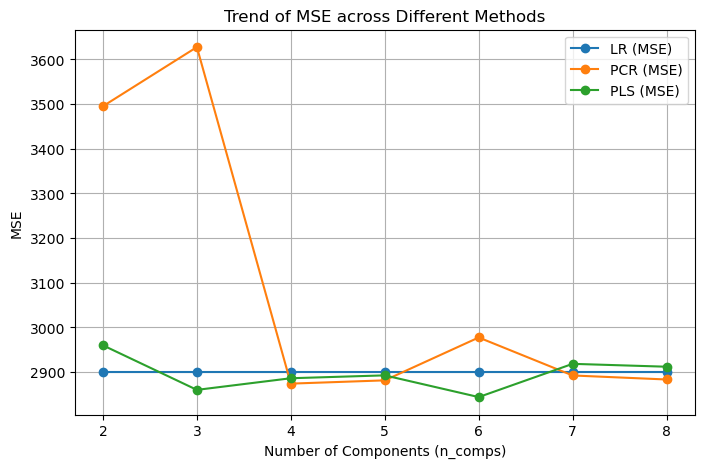

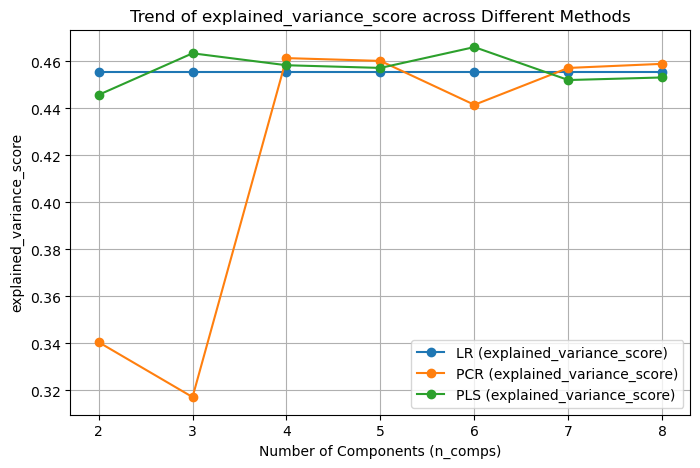

In [37]:

metrics_list = [
    (r2_score, "r2_score"),
    (mean_squared_error, "MSE"),
    (explained_variance_score, "explained_variance_score")
]
# results = {
#     "r2_score": {"LR": [], "PCR": [], "PLS": []},
#     "MSE": {"LR": [], "PCR": [], "PLS": []},
#     "explained_variance_score": {"LR": [], "PCR": [], "PLS": []},
# }
results = {
    name[1]: {"LR": [], "PCR": [], "PLS": []} for name in metrics_list
}
n_comps_range = range(2, 9)


for error, error_name in metrics_list:
    for n_comps in n_comps_range:
        metric_lr, metric_pcr, metric_pls = report_generalisation_errors(error, error_name, n_comps)
        results[error_name]["LR"].append(metric_lr)
        results[error_name]["PCR"].append(metric_pcr)
        results[error_name]["PLS"].append(metric_pls)

for metric_name, methods_results in results.items():
    plt.figure(figsize=(8, 5))
    for method_name, values in methods_results.items():
        plt.plot(n_comps_range, values, label=f"{method_name} ({metric_name})", marker='o')
    
    plt.title(f"Trend of {metric_name} across Different Methods")
    plt.xlabel("Number of Components (n_comps)")
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid()
    plt.show()
